## Check if timeline is complete

In [1]:
import json
import matplotlib.pyplot as plt
import os
from datetime import datetime
from operator import itemgetter

# 3rd party
import numpy
import rasterio
from rasterio.enums import Resampling
from rasterio.io import MemoryFile
from rasterio.transform import Affine
from rasterio.warp import reproject, calculate_default_transform
from rasterio.windows import Window
from shapely.geometry import box

In [112]:
def reproject_img(src, ref):
    transform, width, height = calculate_default_transform(
        src.crs, ref.crs, src.width, src.height, *src.bounds, resolution=ref.transform[0])
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': ref.crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    memfile = MemoryFile()
    intermed_dataset = memfile.open(
        driver='GTiff',
        height=kwargs['height'],
        width=kwargs['width'],
        count=kwargs['count'],
        dtype=kwargs['dtype'],
        crs=kwargs['crs'],
        transform=kwargs['transform'],
        nodata=kwargs['nodata']
    )
    reproject(
        source=rasterio.band(src, 1),
        destination=rasterio.band(intermed_dataset, 1),
        src_transform=intermed_dataset.transform,
        src_crs=intermed_dataset.crs,
        dst_transform=transform,
        dst_crs=ref.crs,
        dst_resolution=transform[0],
        resampling=Resampling.nearest)
    return intermed_dataset


def raster_intersection(raster1, raster2):
    # Check if data on same crs, if different must reproject
    if raster1.crs != raster2.crs:
        raster2 = reproject_img(raster2, raster1)

    bb_raster1 = box(raster1.bounds[0], raster1.bounds[1], raster1.bounds[2], raster1.bounds[3])
    bb_raster2 = box(raster2.bounds[0], raster2.bounds[1], raster2.bounds[2], raster2.bounds[3])


    xminR1, yminR1, xmaxR1, ymaxR1 = raster1.bounds
    xminR2, yminR2, xmaxR2, ymaxR2 = raster2.bounds

    intersection = bb_raster1.intersection(bb_raster2)
    transform = Affine(raster1.res[0], 0.0, intersection.bounds[0], 0.0, -raster1.res[1], intersection.bounds[3])

    p1Y = intersection.bounds[3] - raster1.res[1]/2
    p1X = intersection.bounds[0] + raster1.res[0]/2
    p2Y = intersection.bounds[1] + raster1.res[1]/2
    p2X = intersection.bounds[2] - raster1.res[0]/2
    #row index raster1
    row1R1 = int((ymaxR1 - p1Y)/raster1.res[1])
    #row index raster2
    row1R2 = int((ymaxR2 - p1Y)/raster2.res[1])
    #column index raster1
    col1R1 = int((p1X - xminR1)/raster1.res[0])
    #column index raster2
    col1R2 = int((p1X - xminR2)/raster1.res[0])

    #row index raster1
    row2R1 = int((ymaxR1 - p2Y)/raster1.res[1])
    #row index raster2
    row2R2 = int((ymaxR2 - p2Y)/raster2.res[1])
    #column index raster1
    col2R1 = int((p2X - xminR1)/raster1.res[0])
    #column index raster2
    col2R2 = int((p2X - xminR2)/raster1.res[0])

    width1 = col2R1 - col1R1 + 1
    width2 = col2R2 - col1R2 + 1
    height1 = row2R1 - row1R1 + 1
    height2 = row2R2 - row1R2 + 1

    arr_raster1 = raster1.read(1, window=Window(col1R1, row1R1, width1, height1))
    arr_raster2 = raster2.read(1, window=Window(col1R2, row1R2, width2, height2))

    return arr_raster1, arr_raster2


def search_pairs_l8(sceneids_file='input/l8-sceneids.txt'):
    sceneids = [] # define an empty list
    with open(sceneids_file, 'r') as filehandle: # open file and read the content in a list
        for line in filehandle:
            currentPlace = line[:-1] # remove linebreak which is the last character of the string
            sceneids.append(currentPlace) # add item to the list

    l8_sceneids = []
    for sceneid in sceneids:
        splited_sceneid = sceneid.split('_')
        sensing_date = datetime.strptime(splited_sceneid[3], '%Y%m%d')
        orbit = int(splited_sceneid[2])
        l8_sceneids.append([sceneid, sensing_date, orbit])

    # Order by sensing_date
    l8_sceneids = sorted(l8_sceneids, key=itemgetter(1))

    day_diff = 10
    pairs = []
    uniques = set()
    for i in range(0, len(l8_sceneids)-1):
        # Select with day difference
        if abs((l8_sceneids[i][1] - l8_sceneids[i+1][1]).days) < day_diff:
            # Select from other orbit
            if l8_sceneids[i][2] != l8_sceneids[i+1][2]:
                pairs.append((l8_sceneids[i][0], l8_sceneids[i+1][0]))
                uniques.add(l8_sceneids[i][0])
                uniques.add(l8_sceneids[i+1][0])

    return pairs

def mask_pixel_qa_col2(arr):
    fill = [1]
    high_cloud_confidence = [480, 992]
    cloud = [352, 368, 416, 432, 480, 864, 880, 928, 944, 992]
    cloud_shadow = [328, 392, 840, 904, 1350]

    all_masked_values = fill + high_cloud_confidence + cloud + cloud_shadow
    mask = numpy.copy(arr)
    mask[numpy.where(numpy.isin(mask, all_masked_values))] = 0
    mask[mask>0]=1
    return mask.astype(bool)
###


def mask_pixel_bitwise(mask, flags_list=None, nodata=None):
    if flags_list is None:
        L8_flag = {
            'fill': 1<<0,
            'dilated_cloud': 1<<1,
            'cirrus': 1<<2,
            'cloud': 1<<3,
            'shadow': 1<<4,
            'snow': 1<<5#,
#             'clear': 1<<6,
#             'water': 1<<7
        }
        flags_list = L8_flag
    # first we will create the result mask filled with zeros and the same shape as the mask
    final_mask = numpy.zeros_like(mask)
    if nodata is not None:
        final_mask[mask==nodata] = 1

    # then we will loop through the flags and add the
    for flag in flags_list:
        # get the mask for this flag
        flag_mask = numpy.bitwise_and(mask, flags_list[flag])

        # add it to the final flag
        final_mask = final_mask | flag_mask

    final_mask[final_mask > 0] = 1
    return final_mask.astype(bool)

In [94]:
input_dir = '/home/marujo/Downloads/validation/l8_sr'
output_dir = '/tower/git_hub/marujore/c-factor-article/validation/l8_sr/'

bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']
pairs = search_pairs_l8('/tower/git_hub/marujore/c-factor-article/input/l8-sceneids.txt')

# pairs = [('LC08_L2SP_222081_20200723_20200910_02_T1','LC08_L2SP_223081_20200730_20200908_02_T1'), ('LC08_L2SP_223081_20200730_20200908_02_T1','LC08_L2SP_222081_20200723_20200910_02_T1')] #TEST
pairs = [('LC08_L2SP_223081_20170807_20200903_02_T1','LC08_L2SP_222081_20170816_20200903_02_T1')] #TEST

comparison_metrics = {}

for pair in pairs:
    comparison_metrics[pair[0]+'_x_'+pair[1]] = {}
    # Prepare Cloud Mask
    cloud1_path = os.path.join(input_dir, pair[0]) + '/' + pair[0] + '_QA_PIXEL.TIF'
    cloud2_path = os.path.join(input_dir, pair[1]) + '/' + pair[1] + '_QA_PIXEL.TIF'
    cloud1_ds = rasterio.open(cloud1_path)
    cloud2_ds = rasterio.open(cloud2_path)
    cloud1_arr, cloud2_arr = raster_intersection(cloud1_ds, cloud2_ds)
    mask1 = mask_pixel_bitwise(cloud1_arr, nodata=0)
    mask2 = mask_pixel_bitwise(cloud2_arr, nodata=0)
    mask = numpy.logical_or(mask1, mask2) # Combined mask

    for b in bands:
        #Load files
        print(f"Comparing pair {pair} band {b}")
        raster1_path = os.path.join(input_dir, pair[0]) + '/' + pair[0] + '_SR_' + b + '.TIF'
        raster2_path = os.path.join(input_dir, pair[1]) + '/' + pair[1] + '_SR_' + b + '.TIF'
        raster1_ds = rasterio.open(raster1_path)
        raster2_ds = rasterio.open(raster2_path)

        # Get raster intersection
        raster1_arr, raster2_arr = raster_intersection(raster1_ds, raster2_ds)
        raster1_arr = raster1_arr.astype(float)
        raster2_arr = raster2_arr.astype(float)

        #Apply Cloud mask
        raster1_arr[mask] = numpy.nan
        raster2_arr[mask] = numpy.nan

        # Compare
        abs_dif = abs(raster1_arr - raster2_arr)
        abs_dif_mean = numpy.nanmean(abs_dif)
        abs_sum = abs(raster1_arr + raster2_arr)
        relative_abs_perc = numpy.divide((2*abs_dif), abs_sum)
        relative_abs_perc_mean = numpy.nanmean(relative_abs_perc)*100

        # Store
        comparison_metrics[pair[0]+'_x_'+pair[1]][b] = {}
        comparison_metrics[pair[0]+'_x_'+pair[1]][b]['abs_dif_mean'] = abs_dif_mean
        comparison_metrics[pair[0]+'_x_'+pair[1]][b]['relative_abs_perc_mean'] = relative_abs_perc_mean

comparison_metrics['all_pairs'] = {}
for b in bands:
    comparison_metrics['all_pairs'][b] = {}
    sum_abs_dif = []
    sum_relative_abs_perc = []
    for pair in pairs:
        sum_abs_dif.append(comparison_metrics[pair[0]+'_x_'+pair[1]][b]['abs_dif_mean'])
        sum_relative_abs_perc.append(comparison_metrics[pair[0]+'_x_'+pair[1]][b]['relative_abs_perc_mean'])
    comparison_metrics['all_pairs'][b]['abs_dif_mean'] = numpy.nanmean(sum_abs_dif)
    comparison_metrics['all_pairs'][b]['relative_abs_perc_mean'] = numpy.nanmean(sum_relative_abs_perc)

with open(os.path.join(output_dir,'comparison_metrics.json'), 'w') as file:
    file.write(json.dumps(comparison_metrics))

Comparing pair ('LC08_L2SP_223081_20170807_20200903_02_T1', 'LC08_L2SP_222081_20170816_20200903_02_T1') band B2


<ipython-input-94-2155e8eb21c2>:48: RuntimeWarning: Mean of empty slice
  abs_dif_mean = numpy.nanmean(abs_dif)
<ipython-input-94-2155e8eb21c2>:51: RuntimeWarning: Mean of empty slice
  relative_abs_perc_mean = numpy.nanmean(relative_abs_perc)*100


Comparing pair ('LC08_L2SP_223081_20170807_20200903_02_T1', 'LC08_L2SP_222081_20170816_20200903_02_T1') band B3
Comparing pair ('LC08_L2SP_223081_20170807_20200903_02_T1', 'LC08_L2SP_222081_20170816_20200903_02_T1') band B4
Comparing pair ('LC08_L2SP_223081_20170807_20200903_02_T1', 'LC08_L2SP_222081_20170816_20200903_02_T1') band B5
Comparing pair ('LC08_L2SP_223081_20170807_20200903_02_T1', 'LC08_L2SP_222081_20170816_20200903_02_T1') band B6
Comparing pair ('LC08_L2SP_223081_20170807_20200903_02_T1', 'LC08_L2SP_222081_20170816_20200903_02_T1') band B7


<ipython-input-94-2155e8eb21c2>:66: RuntimeWarning: Mean of empty slice
  comparison_metrics['all_pairs'][b]['abs_dif_mean'] = numpy.nanmean(sum_abs_dif)
<ipython-input-94-2155e8eb21c2>:67: RuntimeWarning: Mean of empty slice
  comparison_metrics['all_pairs'][b]['relative_abs_perc_mean'] = numpy.nanmean(sum_relative_abs_perc)


In [134]:
comparison_metrics = {}

for pair in pairs:
    comparison_metrics[pair[0]+'_x_'+pair[1]] = {}
    # Prepare Cloud Mask
    cloud1_path = os.path.join(input_dir, pair[0]) + '/' + pair[0] + '_QA_PIXEL.TIF'
    cloud2_path = os.path.join(input_dir, pair[1]) + '/' + pair[1] + '_QA_PIXEL.TIF'
    cloud1_ds = rasterio.open(cloud1_path)
    cloud2_ds = rasterio.open(cloud2_path)
    cloud1_arr, cloud2_arr = raster_intersection(cloud1_ds, cloud2_ds)
    mask1 = mask_pixel_bitwise(cloud1_arr, nodata=0)
    mask2 = mask_pixel_bitwise(cloud2_arr, nodata=0)
    mask = numpy.logical_or(mask1, mask2) # Combined mask

    for b in bands:
        #Load files
        print(f"Comparing pair {pair} band {b}")
        raster1_path = os.path.join(input_dir, pair[0]) + '/' + pair[0] + '_SR_' + b + '.TIF'
        raster2_path = os.path.join(input_dir, pair[1]) + '/' + pair[1] + '_SR_' + b + '.TIF'
        raster1_ds = rasterio.open(raster1_path)
        raster2_ds = rasterio.open(raster2_path)

        # Get raster intersection
        raster1_arr, raster2_arr = raster_intersection(raster1_ds, raster2_ds)
        raster1_arr = raster1_arr.astype(float)
        raster2_arr = raster2_arr.astype(float)

        #Apply Cloud mask
        raster1_arr[mask] = numpy.nan
        raster2_arr[mask] = numpy.nan


        # Compare
#         abs_dif = abs(raster1_arr - raster2_arr)
#         abs_dif_mean = numpy.nanmean(abs_dif)
#         abs_sum = abs(raster1_arr + raster2_arr)
#         relative_abs_perc = numpy.divide((2*abs_dif), abs_sum)
#         relative_abs_perc_mean = numpy.nanmean(relative_abs_perc)*100

#         # Store
#         comparison_metrics[pair[0]+'_x_'+pair[1]][b] = {}
#         comparison_metrics[pair[0]+'_x_'+pair[1]][b]['abs_dif_mean'] = abs_dif_mean
#         comparison_metrics[pair[0]+'_x_'+pair[1]][b]['relative_abs_perc_mean'] = relative_abs_perc_mean

Comparing pair ('LC08_L2SP_223081_20170807_20200903_02_T1', 'LC08_L2SP_222081_20170816_20200903_02_T1') band B2


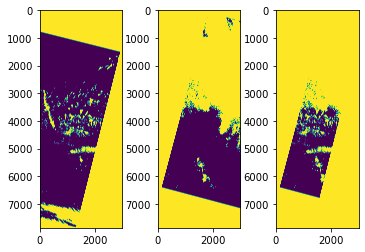

In [135]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(mask1)
ax2.imshow(mask2)
ax3.imshow(mask)

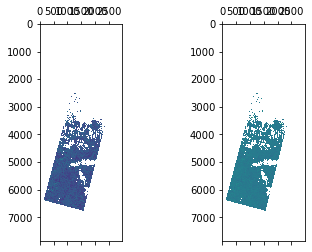

In [136]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.matshow(raster1_arr)
ax2.matshow(raster2_arr)

In [137]:
numpy.nanmean(raster1_arr)

8269.798598376836

In [128]:
numpy.nanmean(raster2_arr)

8260.567765572352

In [131]:
numpy.nanmean(abs_dif)

149.62948773110153

In [130]:
abs_dif

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])